In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as ss
import h5py
import json
import os

from analysis import plot, utils
from bmtool.util import util
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

output_name = 'output_drifting'
model_dir = os.path.join('..', 'V1_bio')
output_dir = os.path.join('..', 'V1_bio_outputs', output_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, output_name)

save_data = False
network_name = 'v1'

### File paths

In [2]:
config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')
nodes_file = os.path.join(model_dir, 'network', 'v1_nodes.h5')
node_types_file = os.path.join(model_dir, 'network', 'v1_node_types.csv')

### Load nodes

In [3]:
if save_data:
    v1_nodes = util.load_nodes_from_paths([{"nodes_file": nodes_file, "node_types_file": node_types_file}])[network_name]
    # population properties
    v1_pop_df = v1_nodes[['pop_name', 'model_type', 'ei', 'location']].set_index('pop_name')
    v1_pop_df = v1_pop_df[~v1_pop_df.index.duplicated(keep='first')]
    # update pop_name
    v1_pop_df['pop_name'] = v1_pop_df.index
    for p, row in v1_pop_df.iterrows():
        row['location'] = row['location'][4:]
        if row['ei'] == 'e':
            name = 'e' + row['location']
            row['pop_name'] = p[:p.find(name) + len(name)]
    v1_nodes['pop_name'] = v1_pop_df.loc[v1_nodes['pop_name'], 'pop_name'].values
    v1_pop_df.set_index('pop_name', inplace=True)
    v1_pop_df = v1_pop_df[~v1_pop_df.index.duplicated(keep='first')]
    v1_pop_df.rename(columns={'location': 'layer'}, inplace=True)
    # add population properties
    v1_pop_df[['cell_type', 'color']] = ''
    for p, row in v1_pop_df.iterrows():
        row['cell_type'] = p[len(row.layer) + (1 if row.model_type == 'biophysical' else 4):] if row.ei == 'i' else 'e'
        row['color'] = plot.pop_color[row.cell_type].replace(' ' if row.model_type == 'biophysical' else 'tab:', '')

#### Save nodes information to data folder

In [4]:
if save_data:
    v1_pop_df.to_csv(os.path.join(data_dir, 'v1_population_properties.csv'))
else:
    v1_pop_df = pd.read_csv(os.path.join(data_dir, 'v1_population_properties.csv'), index_col='pop_name')

bio_idx = v1_pop_df['model_type'] == 'biophysical'
bio_pop_names = v1_pop_df.index[bio_idx].tolist()
lif_pop_names = v1_pop_df.index[~bio_idx].tolist()
display(v1_pop_df.loc[bio_pop_names])
display(v1_pop_df.loc[lif_pop_names])

,model_type,ei,layer,cell_type,color
pop_name,,,,,
i1Htr3a,biophysical,i,1,Htr3a,tab:purple
e23,biophysical,e,23,e,tab:red
i23Htr3a,biophysical,i,23,Htr3a,tab:purple
i23Pvalb,biophysical,i,23,Pvalb,tab:blue
i23Sst,biophysical,i,23,Sst,tab:green
e4,biophysical,e,4,e,tab:red
i4Htr3a,biophysical,i,4,Htr3a,tab:purple
i4Pvalb,biophysical,i,4,Pvalb,tab:blue
i4Sst,biophysical,i,4,Sst,tab:green


,model_type,ei,layer,cell_type,color
pop_name,,,,,
LIFi1Htr3a,point_process,i,1,Htr3a,purple
LIFe23,point_process,e,23,e,red
LIFi23Htr3a,point_process,i,23,Htr3a,purple
LIFi23Pvalb,point_process,i,23,Pvalb,blue
LIFi23Sst,point_process,i,23,Sst,green
LIFe4,point_process,e,4,e,red
LIFi4Htr3a,point_process,i,4,Htr3a,purple
LIFi4Pvalb,point_process,i,4,Pvalb,blue
LIFi4Sst,point_process,i,4,Sst,green


In [5]:
if save_data:
    bio_idx = v1_nodes['model_type'] == 'biophysical'
    v1_bio_nodes = v1_nodes[bio_idx].copy() # choose biophysical neurons
    v1_lif_nodes = v1_nodes[~bio_idx].copy() # choose point neurons

    # IDs for raster plot in a reverse order of layers
    v1_bio_nodes['raster_id'] = v1_bio_nodes.index
    n = len(v1_bio_nodes)
    for p in bio_pop_names:
        idx = v1_bio_nodes['pop_name'] == p
        n_pop = idx.sum()
        v1_bio_nodes.loc[idx, 'raster_id'] = range(n - n_pop, n)
        n -= n_pop

    v1_lif_nodes['raster_id'] = v1_lif_nodes.index
    n = len(v1_lif_nodes)
    for p in lif_pop_names:
        idx = v1_lif_nodes['pop_name'] == p
        n_pop = idx.sum()
        v1_lif_nodes.loc[idx, 'raster_id'] = range(n - n_pop, n)
        n -= n_pop

    v1_bio_nodes.to_csv(os.path.join(data_dir, 'v1_biophysical_nodes.csv'))
    v1_lif_nodes.to_csv(os.path.join(data_dir, 'v1_point_process_nodes.csv'))
else:
    v1_bio_nodes = pd.read_csv(os.path.join(data_dir, 'v1_biophysical_nodes.csv'), index_col='node_id')
    v1_lif_nodes = pd.read_csv(os.path.join(data_dir, 'v1_point_process_nodes.csv'), index_col='node_id')
    v1_nodes = pd.concat((v1_bio_nodes, v1_lif_nodes))

### Load spikes

In [6]:
with h5py.File(spikes_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })

# choose only biophysical cells
bio_idx = np.array([nid in v1_bio_nodes.index for nid in spikes_df['node_ids']])
spikes_bio_df = spikes_df[bio_idx].copy()
spikes_bio_df.sort_values(by='timestamps', inplace=True, ignore_index=True)
spikes_lif_df = spikes_df[~bio_idx].copy()
spikes_lif_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

# spikes of populations
spikes_bio_df[['pop_name', 'raster_id']] = v1_bio_nodes.loc[spikes_bio_df['node_ids'], ['pop_name', 'raster_id']].values
pop_spike_bio = utils.get_populations(spikes_bio_df, bio_pop_names)
spikes_lif_df[['pop_name', 'raster_id']] = v1_lif_nodes.loc[spikes_lif_df['node_ids'], ['pop_name', 'raster_id']].values
pop_spike_lif = utils.get_populations(spikes_lif_df, lif_pop_names)

### Raster plot

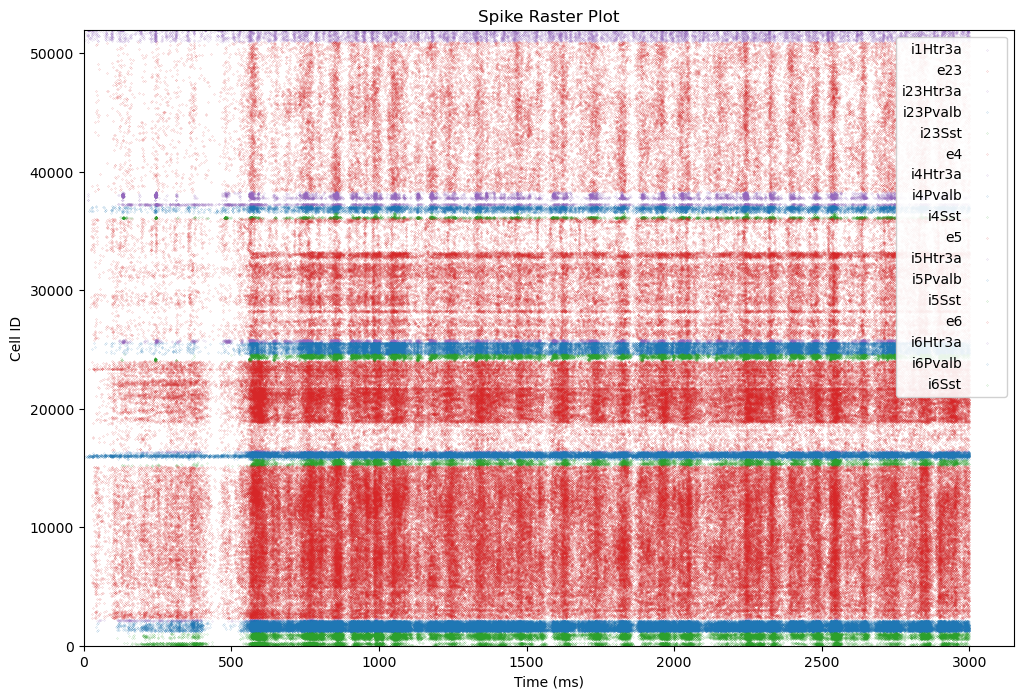

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = plot.raster(pop_spike_bio, v1_pop_df['color'].to_dict(), id_column='raster_id', s=0.01, ax=ax)
plt.show()

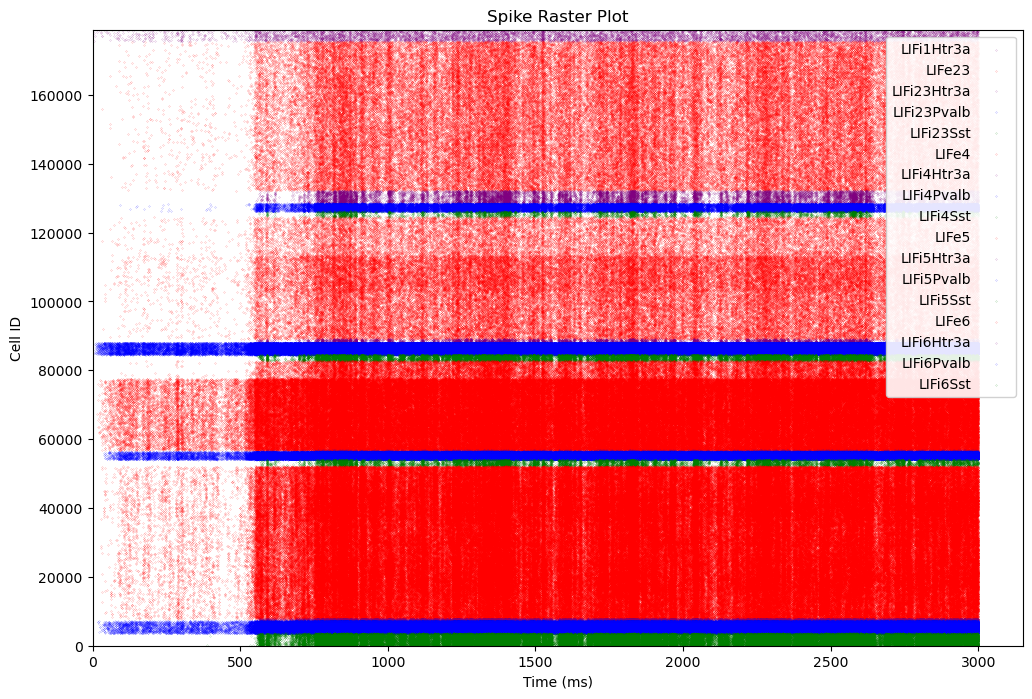

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = plot.raster(pop_spike_lif, v1_pop_df['color'].to_dict(), id_column='raster_id', s=0.01, ax=ax)
plt.show()

### Firing rate

In [9]:
baseline_window = (.1,  .5) # seconds
baseline_frs = plot.firing_rate(spikes_df, num_cells=len(v1_nodes), time_windows=baseline_window)
DG_window = (.5, 3.) # drifting grating time window
DG_frs = plot.firing_rate(spikes_df, num_cells=len(v1_nodes), time_windows=DG_window)

In [10]:
v1_pop_ids = utils.get_populations(v1_nodes, v1_pop_df.index, only_id=True)
pop_baseline_frs = {p: baseline_frs[nid] for p, nid in v1_pop_ids.items()}
pop_DG_frs = {p: baseline_frs[nid] for p, nid in v1_pop_ids.items()}


pop_baseline_frs_df = utils.population_statistics(pop_baseline_frs)
pop_DG_frs_df = utils.population_statistics(pop_DG_frs)
print('Baseline firing rate (Hz)')
display(pop_baseline_frs_df)
print('Drifting grating firing rate (Hz)')
display(pop_DG_frs_df)

Baseline firing rate (Hz)


,mean,stdev
LIFi1Htr3a,0.156064,0.657791
i1Htr3a,1.531532,3.196400
LIFe23,0.022597,0.253656
e23,0.161951,0.693614
LIFi23Htr3a,0.000000,0.000000
i23Htr3a,2.152213,3.343967
LIFi23Pvalb,0.021863,0.232763
i23Pvalb,1.007812,1.926364
LIFi23Sst,0.000000,0.000000
i23Sst,1.250000,2.852328


Drifting grating firing rate (Hz)


,mean,stdev
LIFi1Htr3a,0.156064,0.657791
i1Htr3a,1.531532,3.196400
LIFe23,0.022597,0.253656
e23,0.161951,0.693614
LIFi23Htr3a,0.000000,0.000000
i23Htr3a,2.152213,3.343967
LIFi23Pvalb,0.021863,0.232763
i23Pvalb,1.007812,1.926364
LIFi23Sst,0.000000,0.000000
i23Sst,1.250000,2.852328


In [11]:
layers = v1_pop_df['layer'].unique()
model_types = v1_pop_df['model_type'].unique()[::-1]

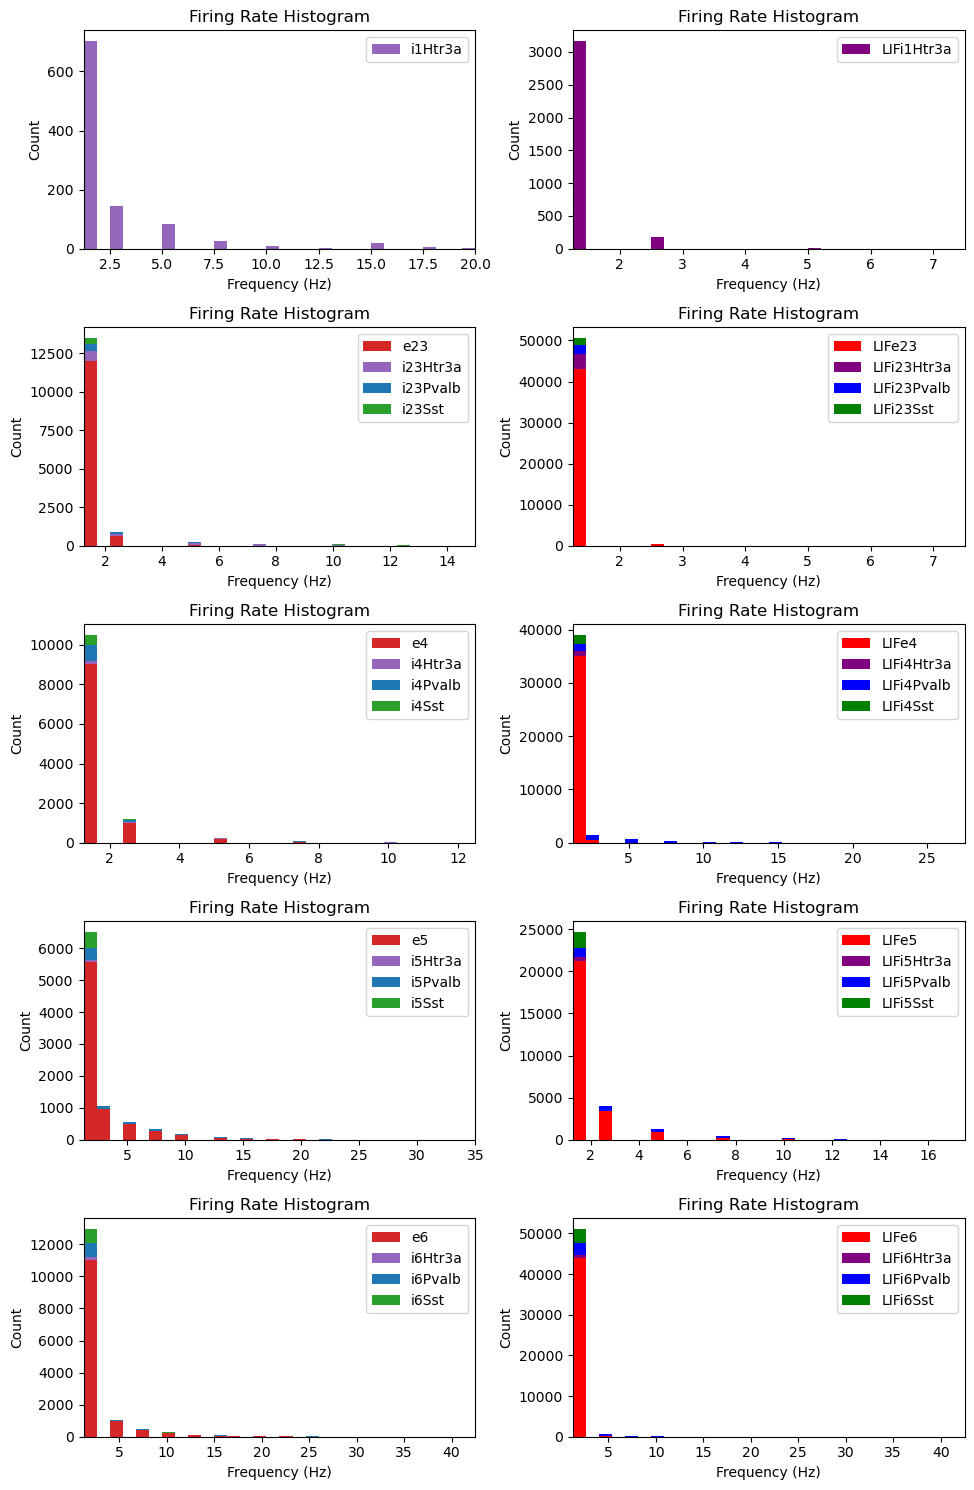

In [12]:
min_fr = 0.5 / plot.total_duration(baseline_window)

_, axs = plt.subplots(len(layers), 2, figsize=(10, 3 * len(layers)))
for j, M in enumerate(model_types):
    for i, L in enumerate(layers):
        ax = axs[i, j]
        pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
        pop_fr = {p: pop_baseline_frs[p] for p in pops}
        plot.firing_rate_histogram(pop_fr, v1_pop_df.loc[pops, 'color'], bins=30, min_fr=min_fr,
                                   logscale=False, stacked=True, ax=ax)
plt.tight_layout()
plt.show()

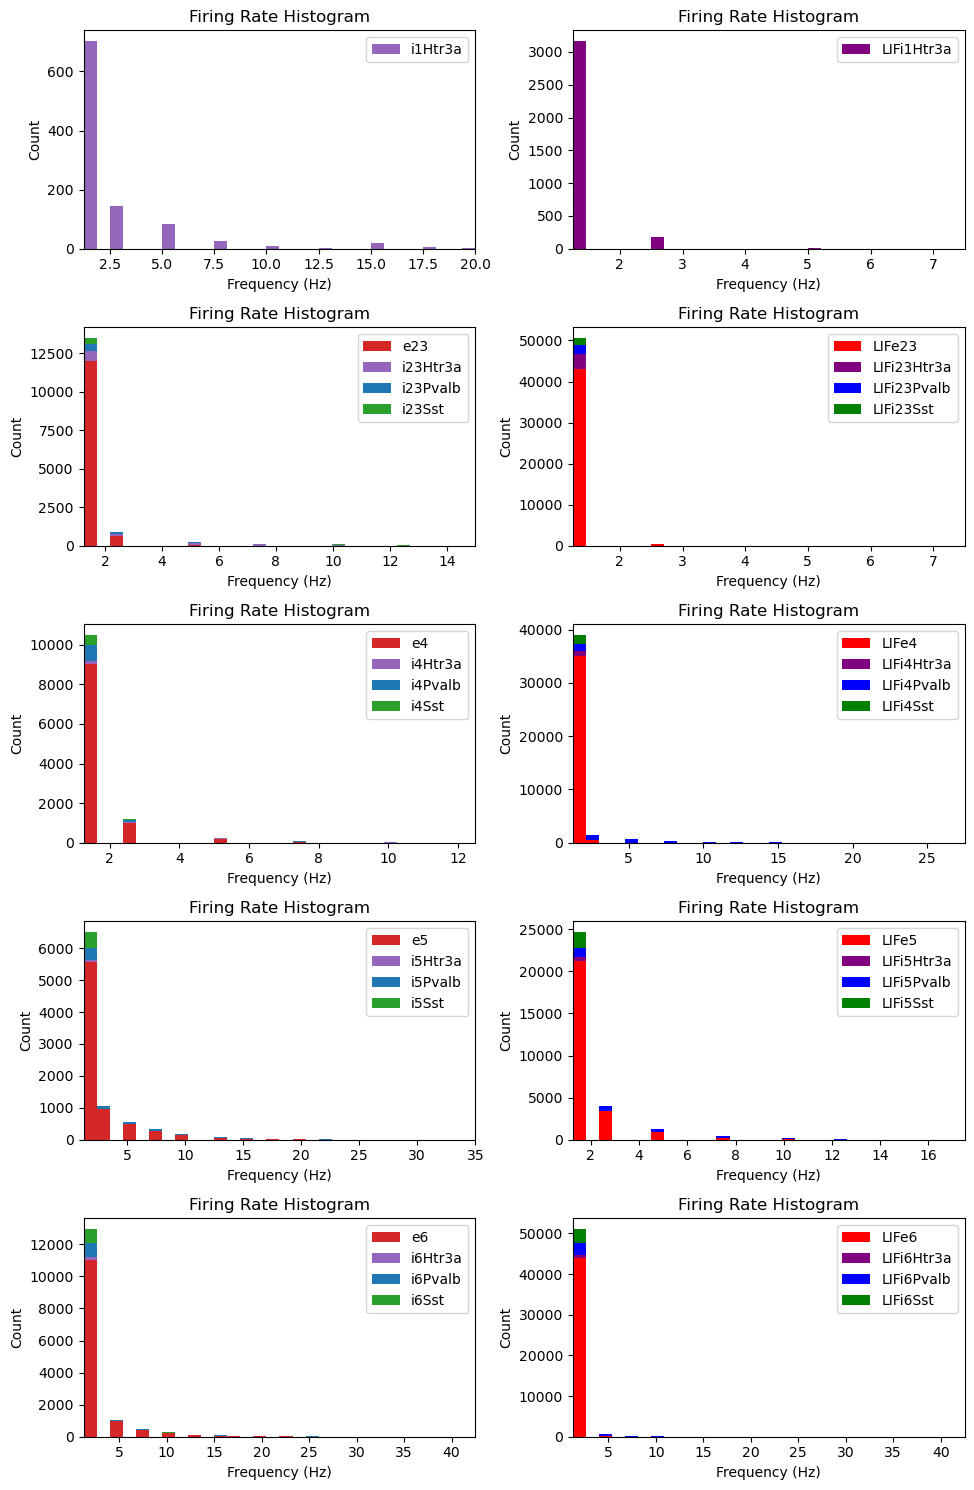

In [13]:
_, axs = plt.subplots(len(layers), 2, figsize=(10, 3 * len(layers)))
for j, M in enumerate(model_types):
    for i, L in enumerate(layers):
        ax = axs[i, j]
        pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
        pop_fr = {p: pop_DG_frs[p] for p in pops}
        plot.firing_rate_histogram(pop_fr, v1_pop_df.loc[pops, 'color'], bins=30, min_fr=min_fr,
                                   logscale=False, stacked=True, ax=ax)
plt.tight_layout()
plt.show()

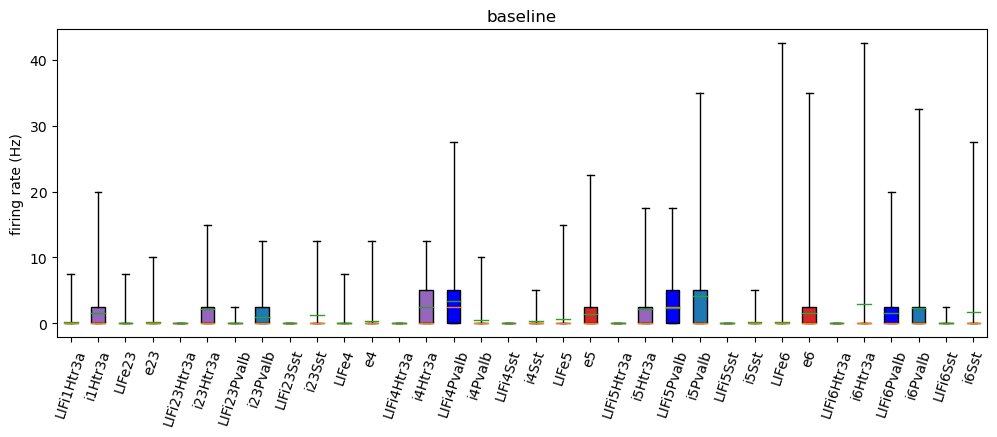

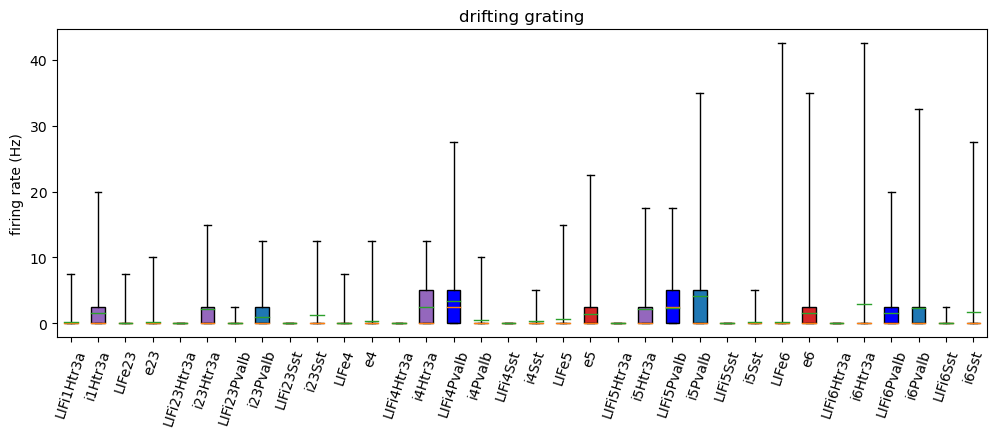

In [14]:
for title, frs_df in {'baseline': pop_baseline_frs, 'drifting grating': pop_DG_frs}.items():
    plt.figure(figsize=(12, 4))
    bplot = plt.boxplot(frs_df.values(), labels=frs_df.keys(), whis=(0., 100.),
                        showmeans=True, meanline=True, showfliers=False, showcaps=True,
                        widths=0.5, patch_artist=True,  # fill with color
                        meanprops={'linestyle': '-'})
    for patch, color in zip(bplot['boxes'], v1_pop_df.loc[frs_df.keys(), 'color']):
        patch.set_facecolor(color)
    plt.ylabel('firing rate (Hz)')
    plt.xticks(rotation=72, ha='center')
    plt.title(title)
plt.show()

### Population spike rate time histogram

In [15]:
with open(config_file, 'r') as f:
    t_stop = json.load(f)['run']['tstop']

fs = 2000.
dt = 1000 / fs
time = np.array([0, t_stop, dt])
pop_rspk = {p: plot.pop_spike_rate(spk['timestamps'], time) for p, spk in (pop_spike_bio | pop_spike_lif).items()}

In [16]:
if not os.path.isdir(trial_dir):
    os.mkdir(trial_dir)

spike_rate_file = os.path.join(trial_dir, 'spike_rate.h5')
with h5py.File(spike_rate_file, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(v1_pop_ids[p])